In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"America/Toronto\"")

In [ ]:
hex_project_id = _hex_json.loads("\"b36107a4-3b10-4373-8196-60f29b0349bb\"")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

In [ ]:
# Import Python packages
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import os
import hextoolkit

# Import Snowflake modules
from snowflake.snowpark import Session 
import snowflake.snowpark.functions as F 
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

In [ ]:
hex_snowflake_conn = hextoolkit.get_data_connection('demo309')
session = hex_snowflake_conn.get_snowpark_session()
session.use_role('datasci')
session.use_warehouse('datasci_wh')
session.use_database('analytics')
session.use_schema('readmit')
print(session.sql("select current_role(), current_warehouse(), current_database(), current_schema(), current_region(), current_client()").collect())

[Row(CURRENT_ROLE()='DATASCI', CURRENT_WAREHOUSE()='DATASCI_WH', CURRENT_DATABASE()='ANALYTICS', CURRENT_SCHEMA()='READMIT', CURRENT_REGION()='PUBLIC.AWS_US_WEST_2', CURRENT_CLIENT()='PythonSnowpark 1.2.0')]


In [ ]:
#Create a Snowpark dataframe to start manipulating our data
readmissions_df=session.table('readmissions_enriched')

In [ ]:
#Explore 10 rows of data
readmissions_df.sample(n=10).show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CITY_LAT"  |"CITY_LONG"  |"HOSPITAL_LAT"  |"HOSPITAL_LONG"  |"HOSPITAL_NAME"                                   |"HOSPITAL_STATE"  |"DIAGNOSIS"  |"PATIENT_NUMBER"  |"DV_READMIT_FLAG"  |"A

In [ ]:
# How large is this Snowpark dataframe? 
import sys
snowpark_size = sys.getsizeof(readmissions_df) / (1024*1024)
print(f"Snowpark DataFrame Size (snowpark_df): {snowpark_size:.2f} MB")

Snowpark DataFrame Size (snowpark_df): 0.00 MB


In [ ]:
#Select the columns that are most likely to correlate with our binary target. 
readmissions_df_features = readmissions_df.select("PATIENT_AGE", "BMI", "LENGTH_OF_STAY", "ORDER_SET_USED", "CHRONIC_CONDITIONS_NUMBER",  "SBUX_COUNT", "DV_READMIT_FLAG" )

# Filer Sort
nj_df = readmissions_df.filter(F.col("HOSPITAL_STATE") == 'NJ').order_by(["DV_READMIT_FLAG", "DIAGNOSIS"], ascending=[0, 0])

# Display
nj_df.show(n=20)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CITY_LAT"  |"CITY_LONG"  |"HOSPITAL_LAT"  |"HOSPITAL_LONG"  |"HOSPITAL_NAME"                                   |"HOSPITAL_STATE"  |"DIAGNOSIS"  |"PATIENT_NUMBER"  |"DV_READMIT_FLAG"  |"AD

In [ ]:
nj_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT  *  FROM readmissions_enriched WHERE ("HOSPITAL_STATE" = 'NJ') ORDER BY "DV_READMIT_FLAG" DESC NULLS LAST, "DIAGNOSIS" DESC NULLS LAST
Logical Execution Plan:
GlobalStats:
    partitionsTotal=1
    partitionsAssigned=1
    bytesAssigned=5365760
Operations:
1:0     ->Result  READMISSIONS_ENRICHED.CITY_LAT, READMISSIONS_ENRICHED.CITY_LONG, READMISSIONS_ENRICHED.HOSPITAL_LAT, READMISSIONS_ENRICHED.HOSPITAL_LONG, READMISSIONS_ENRICHED.HOSPITAL_NAME, READMISSIONS_ENRICHED.HOSPITAL_STATE, READMISSIONS_ENRICHED.DIAGNOSIS, READMISSIONS_ENRICHED.PATIENT_NUMBER, READMISSIONS_ENRICHED.DV_READMIT_FLAG, READMISSIONS_ENRICHED.ADMIT_DATE, READMISSIONS_ENRICHED.LENGTH_OF_STAY, READMISSIONS_ENRICHED.PRIOR_IP_ADMITS, READMISSIONS_ENRICHED.CHRONIC_CONDITIONS_NUMBER, READMISSIONS_ENRICHED.PATIENT_AGE, READMISSIONS_ENRICHED.ORDER_SET_USED, READMISSIONS_ENRICHED.HOSPITAL_ID, READMISSIONS_ENRICHED.HOSPITAL_ADDRESS, READMISSIONS_ENRICHED.HOSPIT

In [ ]:
#Print Number of OBS
print('The total number of patients in the dataset is:',readmissions_df_features.count())
#Print Readmits
print('The number of patients with a readmission:',readmissions_df_features.filter(col('"DV_READMIT_FLAG"')==1).count())
#Print Nonreadmits
print('The number of patients without a readmission:',readmissions_df_features.filter(col('"DV_READMIT_FLAG"')==0).count())

The total number of patients in the dataset is: 75675
The number of patients with a readmission: 17007
The number of patients without a readmission: 58668


In [ ]:
#Display the count, mean, standard deviation, min, and max values for our variables
readmissions_df_features.describe().show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"PATIENT_AGE"       |"BMI"               |"LENGTH_OF_STAY"   |"ORDER_SET_USED"     |"CHRONIC_CONDITIONS_NUMBER"  |"SBUX_COUNT"        |"DV_READMIT_FLAG"   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |75675.0             |75675.0             |75675.0            |75675.0              |75675.0                      |35931.0             |75675.0             |
|mean       |58.088008           |24.50865147010241   |4.816597           |0.399498             |2.015738                     |2.530016            |0.224737            |
|stddev     |13.011103565801019  |3.5000372760173843  |2.779307287796727  |0.48979791751292695  |0.4733318075092778           |1.4613719581270197  |0.

In [ ]:
#Count the number of null/missing values for each input value. Perhaps we may need to do some imputation
column_names=readmissions_df_features.columns
for i in column_names:
    print('Column',i,'has',readmissions_df_features.filter(col(i).isNull()).count(),'missing values!')

Column PATIENT_AGE has 0 missing values!
Column BMI has 0 missing values!
Column LENGTH_OF_STAY has 0 missing values!
Column ORDER_SET_USED has 0 missing values!
Column CHRONIC_CONDITIONS_NUMBER has 0 missing values!
Column SBUX_COUNT has 39744 missing values!
Column DV_READMIT_FLAG has 0 missing values!


In [ ]:
#Since our zip codes without any Starbucks locations show up as null, let's replace those missing values with 0 for our model
readmissions_df_features = readmissions_df_features.fillna(0, subset="SBUX_COUNT")
readmissions_df_features.show()

--------------------------------------------------------------------------------------------------------------------------------
|"PATIENT_AGE"  |"BMI"  |"LENGTH_OF_STAY"  |"ORDER_SET_USED"  |"CHRONIC_CONDITIONS_NUMBER"  |"SBUX_COUNT"  |"DV_READMIT_FLAG"  |
--------------------------------------------------------------------------------------------------------------------------------
|54             |25.8   |3                 |0                 |2                            |0             |0                  |
|60             |30.5   |2                 |1                 |2                            |0             |0                  |
|61             |25.2   |2                 |1                 |2                            |0             |0                  |
|51             |30.4   |3                 |0                 |2                            |0             |0                  |
|61             |34.8   |3                 |1                 |2                            |0   

In [ ]:
#No more missing values
for i in column_names:
    print('Column',i,'has',readmissions_df_features.filter(col(i).isNull()).count(),'missing values!')

Column PATIENT_AGE has 0 missing values!
Column BMI has 0 missing values!
Column LENGTH_OF_STAY has 0 missing values!
Column ORDER_SET_USED has 0 missing values!
Column CHRONIC_CONDITIONS_NUMBER has 0 missing values!
Column SBUX_COUNT has 0 missing values!
Column DV_READMIT_FLAG has 0 missing values!


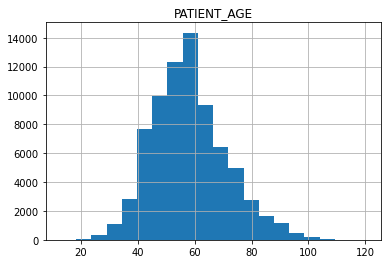

In [ ]:
#Visually examine the distribution of patient age to see if any transformations should be applied
ax = readmissions_df_features.to_pandas().hist(column="PATIENT_AGE", bins=20)


In [ ]:
#Create a pandas dataframe to put the correlations into.
corr_df=pd.DataFrame(columns=column_names,index=column_names,dtype=float)


#Calculate the correlations
for i,j in combinations(column_names,2):
    corr_df.at[i,j]=round(readmissions_df_features.corr(col(i),col(j)),2)
    corr_df.at[j,i]=corr_df.at[i,j] 

#The diagonal will always be set to 1 since it is matching variables
np.fill_diagonal(corr_df.values, 1.0)

#See the raw table
corr_df

,PATIENT_AGE,BMI,LENGTH_OF_STAY,ORDER_SET_USED,CHRONIC_CONDITIONS_NUMBER,SBUX_COUNT,DV_READMIT_FLAG
PATIENT_AGE,1.00,0.0,0.28,0.17,0.04,-0.01,0.58
BMI,0.00,1.0,0.00,-0.00,-0.00,-0.00,0.00
LENGTH_OF_STAY,0.28,0.0,1.00,0.14,0.02,-0.00,0.49
ORDER_SET_USED,0.17,-0.0,0.14,1.00,0.02,-0.01,0.30
CHRONIC_CONDITIONS_NUMBER,0.04,-0.0,0.02,0.02,1.00,-0.01,0.06
SBUX_COUNT,-0.01,-0.0,-0.00,-0.01,-0.01,1.00,-0.01
DV_READMIT_FLAG,0.58,0.0,0.49,0.30,0.06,-0.01,1.00


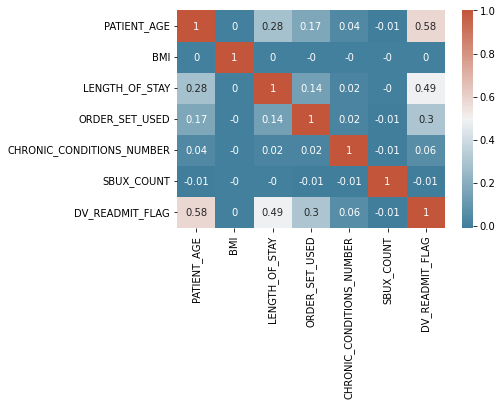

In [ ]:
#Create a heatmap of the correlations. Examine if there is any predictive power or multicollinearlity.
sns.heatmap(corr_df, cmap=sns.diverging_palette(230, 20, as_cmap=True), annot=True);

In [ ]:
#Save our model-ready table with imputed values as a Snowflake table
readmissions_df_features.write.mode("overwrite").save_as_table("analytics.readmit.readmissions_imp")

In [ ]:
#The staging area will surface as place to put python objects for future use (for example model scoring)
session.sql("CREATE OR REPLACE STAGE readmissions_model_stage").collect()

[Row(status='Stage area READMISSIONS_MODEL_STAGE successfully created.')]

In [ ]:
#Define a function for building a logistic regression model
def train_model(session: Session, 
    training_table: str, 
    feature_columns: list, 
    target_variable: str,
    model_name: str,
) -> T.Variant:
    
    #Import packages for modeling
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from joblib import dump

    #Specify the table for training the model. The pandas dataframe will live on the Snowflake compute.
    readmissions_py_df=session.table(training_table).to_pandas()
    
    #Create our input and output features
    X=readmissions_py_df[feature_columns]
    y=readmissions_py_df[target_variable]

    #Split the data into a train and test dataset. 75% train / 25% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 99)

    #Fit the model
    model = LogisticRegression().fit(X_train,y_train)
    
  # Save model
    dump(model, "/tmp/" + model_name)
    session.file.put(
        "/tmp/" + model_name,
        "@readmissions_model_stage",
        auto_compress=False,
        overwrite=True
    )


    #Check and return model accuracy based on our two data sets
    return {"Misclassification Rate on Train": round(model.score(X_train, y_train),3), 
            "Misclassification Rate on Test": round(model.score(X_test, y_test),3)}



In [ ]:
#In Snowflake, when running a model function - we need to first register it as a stored procedure. We will store the function in a stage created earlier.
train_model_snowflake = session.sproc.register(func=train_model, 
                                                name="sproc_train_model", 
                                                is_permanent=True, 
                                                replace=True, 
                                                stage_location="@readmissions_model_stage", 
                                                packages=["snowflake-snowpark-python", "scikit-learn", "joblib"])

In [ ]:
session.sql("alter warehouse datasci_wh set warehouse_size = xlarge").collect()

[Row(status='Statement executed successfully.')]

In [ ]:
# Specify input variables, the labeled variable, and the input dataset
training_table = "analytics.readmit.readmissions_imp" 
feature_cols = ["PATIENT_AGE",'BMI','LENGTH_OF_STAY','ORDER_SET_USED','CHRONIC_CONDITIONS_NUMBER', 'SBUX_COUNT'] 
target_col = "DV_READMIT_FLAG"
model_name = "readmit_logistic.sav"


# Call the training stored procedure and see the misclassification rate outputs
feature_contributions = train_model_snowflake(session,
    training_table,
    feature_cols,
    target_col,
    model_name)
print(feature_contributions)

{
  "Misclassification Rate on Test": 0.905,
  "Misclassification Rate on Train": 0.902
}


In [ ]:
session.sql("alter warehouse datasci_wh set warehouse_size=small").collect()

[Row(status='Statement executed successfully.')]

In [ ]:
#Define a function for prediction with our model file
def logistic_predict(X: pd.DataFrame) -> pd.Series:
    
    # Import packages
    import sys
    from joblib import load

    # Get the import directory where the model file is stored
    import_dir = sys._xoptions["snowflake_import_directory"]

    # Load the model
    model = load(import_dir + "readmit_logistic.sav")

    # Get predictions
    predictions = model.predict(X)

    # Return rounded predictions
    return predictions.round(2)

In [ ]:
#Register our UDF for use
logistic_predict_sales_snowflake = session.udf.register(
    func=logistic_predict,
    name="udf_logistic_readmit_predict",
    stage_location="@readmissions_model_stage",
    input_types=[T.FloatType()] * len(feature_cols),
    return_type=T.FloatType(),
    replace=True,
    is_permanent=True,
    imports=["@readmissions_model_stage/readmit_logistic.sav"],
    packages=["scikit-learn", "joblib"]
)

In [ ]:
#How does our model fair on our train dataset?
train_pred = readmissions_df_features.select(
    "DV_READMIT_FLAG",
    logistic_predict_sales_snowflake(*feature_cols).alias("prediction")
)
train_pred.show()

------------------------------------
|"DV_READMIT_FLAG"  |"PREDICTION"  |
------------------------------------
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|1                  |1.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
------------------------------------



In [ ]:
#Predict readmissions of our new patients
new_patients_df=session.table('new_patients_enriched')
new_patients_imp = new_patients_df.fillna(0, subset="SBUX_COUNT")
new_patients_imp.write.mode("overwrite").save_as_table("analytics.readmit.new_patients_imp")
new_patients_predictions_df = new_patients_imp.select("NPI", "HOSPITAL_LAT", "HOSPITAL_LONG", "HOSPITAL_NAME", "HOSPITAL_STATE", logistic_predict_sales_snowflake(*feature_cols).alias("predicted_readmission"))
new_patients_predictions_df.show()

---------------------------------------------------------------------------------------------------------------------
|"NPI"       |"HOSPITAL_LAT"  |"HOSPITAL_LONG"  |"HOSPITAL_NAME"       |"HOSPITAL_STATE"  |"PREDICTED_READMISSION"  |
---------------------------------------------------------------------------------------------------------------------
|1053675397  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1891067815  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1093063927  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1427401413  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1518982958  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1285071134  |NULL            |NULL             |OCEAN M

In [ ]:
#Save our predicted output Snowpark dataframe as a permanent table
new_patients_predictions_df.write.mode("overwrite").save_as_table("new_patient_predictions_snowpark")

In [ ]:
# import jinja2
# raw_query = """
#     create or replace table analytics.readmit.new_jersey_slice_snowpark as 
#         select distinct(hospital_name), hospital_lat, hospital_long, sum(predicted_readmission) as total_pred_readmits
#         from analytics.readmit.new_patient_predictions_snowpark
#         where hospital_state='NJ'
#         group by hospital_name, hospital_lat, hospital_long;
#     
# """
# sql_query = jinja2.Template(raw_query).render(vars())

In [ ]:
import plotly.express as px


# Pull location predictions into a pandas DataFrame
nj_predictions=session.table('new_jersey_slice_snowpark')
nj_predictions_df = nj_predictions.to_pandas()

# Visualize on a map
# This is a prototype of what we'll eventually make in Tableau
# Where are our providers with the most predicted readmissions?
fig = px.scatter_mapbox(
    nj_predictions_df, 
    lat="HOSPITAL_LAT", 
    lon="HOSPITAL_LONG", 
    hover_name="HOSPITAL_NAME", 
    size="TOTAL_PRED_READMITS",
    color="TOTAL_PRED_READMITS",
    zoom=8, 
    height=800,
    width=1000
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [ ]:
session.close()